### Part 01. Load packages and libs

In [48]:
import warnings
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

warnings.filterwarnings("ignore")

### Part 02. Writing a custom dataset for Blood Cell Segmemtation dataset, write data loader to load data for train model

In [49]:
TRAIN_IMG_DIR = "datasets/kvasir_capsule/train/images"
TRAIN_MASK_DIR = "datasets/kvasir_capsule/train/masks"
VAL_IMG_DIR = "datasets/kvasir_capsule/test/images"
VAL_MASK_DIR = "datasets/kvasir_capsule/test/masks"

In [50]:
class BloodCellDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None) -> None:
        super(BloodCellDataset, self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir, self.images[index])

        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),
                        dtype=np.float32)
        # mask[mask == 255.0] = 1.0
        mask = np.where(mask > 155.0, 1.0, 0.0)

        if self.transform is not None:
            augemantations = self.transform(image=image, mask=mask)
            image = augemantations['image']
            mask = augemantations['mask']
        return image, mask

In [51]:
def get_data_loaders(
        train_dir, train_mask_dir, val_dir, val_maskdir, batch_size,
        train_transform, val_transform):

    train_ds = BloodCellDataset(
        image_dir=train_dir, mask_dir=train_mask_dir,
        transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = BloodCellDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

In [52]:
train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [53]:
BATCH_SIZE = 2

train_loader, val_loader = get_data_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    BATCH_SIZE,
    train_transform,
    val_transforms
)

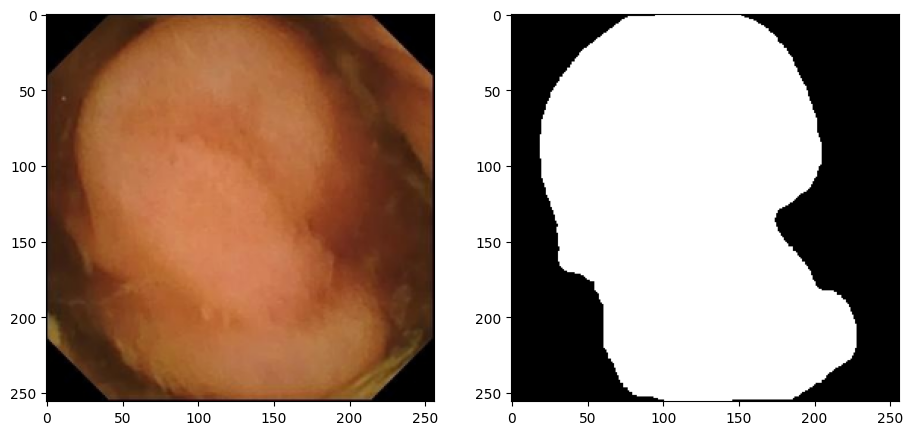

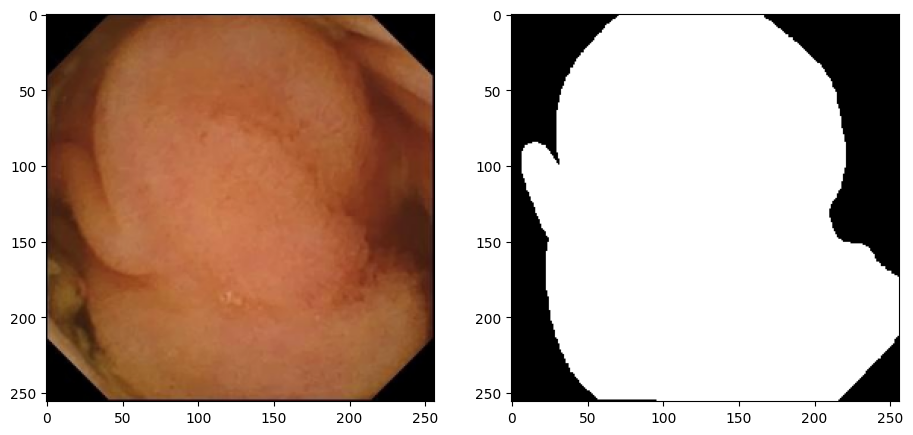

In [54]:
def show_transformed(data_loader):
    batch = next(iter(data_loader))
    images, labels = batch

    for img, mask in zip(images, labels):
        plt.figure(figsize=(11, 11))

        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(img, (1, 2, 0)))

        plt.subplot(1, 2, 2)
        # plt.imshow(mask.reshape(mask.shape[0], mask.shape[1], 1))
        plt.imshow(mask, cmap="gray")


show_transformed(val_loader)

### Part 03. Implement the deeplabv3+ model from scratch with pytorch

In [55]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [56]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(AttentionUNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(512, 512, 256)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(64, 64, 32)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((self.att4(d4, e4), d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((self.att3(d3, e3), d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((self.att2(d2, e2), d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((self.att1(d1, e1), d1), dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return out

### Part 04. Define the Dice loss func and IoU func because we are implementing from scratch

In [57]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()
        self.bce_losss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets, smooth=1):
        BCE = self.bce_losss(inputs, targets)
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(
            inputs.sum() + targets.sum() + smooth)
        Dice_BCE = BCE + dice_loss
        return Dice_BCE


class IOU(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IOU, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + smooth)/(union + smooth)
        return IoU

### Part 05. Define some hyper-parameters and vars to prepare for train the model

In [58]:
# model = Deeplabv3Plus(num_classes=1).to(DEVICE)
# model = UNetPlusPlus(in_channels=3, out_channels=1).to(DEVICE)
model = AttentionUNet(in_channels=3, out_channels=1).to(DEVICE)

loss_fn = DiceBCELoss()

iou_fn = IOU()
scaler = torch.cuda.amp.GradScaler()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_iou = []
train_loss = []
train_dice = []

def save_checkpoint(state, filename="model.pth.tar"):
    print("=> Saving checkpoint")
    # torch.save(state, filename)

In [59]:
model

AttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

In [60]:
print(model)

AttentionUNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True

### Part 06. Start training model trained

In [61]:
start_time = time.time()

# let's train it just for 2 epochs
NUM_EPOCHS = 32

for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}")

    iterations = 0
    iter_loss = 0.0
    iter_iou = 0.0

    batch_loop = tqdm(train_loader)
    for batch_idx, (data, targets) in enumerate(batch_loop):

        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        with torch.autocast(device_type=DEVICE, dtype=torch.bfloat16):
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            iou = iou_fn(predictions, targets)

            iter_loss += loss.item()
            iter_iou += iou.item()

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        iterations += 1
        batch_loop.set_postfix(diceloss=loss.item(), iou=iou.item())

    train_loss.append(iter_loss / iterations)
    train_iou.append(iter_iou / iterations)
    # print(
    #     f"Epoch: {epoch+1}/{NUM_EPOCHS}, Training loss: {round(train_loss[-1] , 3)}")
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, IoU score: {iter_iou / iterations}")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    # save_checkpoint(checkpoint)

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    # print(
    #     f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    # )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Total num_correct/num_pixels: {num_correct}/{num_pixels} => {num_correct/num_pixels}"
    )
    print(
        f"Epoch: {epoch+1}/{NUM_EPOCHS}, Dice score: {dice_score / len(val_loader)}")
    train_dice.append(dice_score / len(val_loader))
    model.train()

print("done ..")

end_time = time.time()
training_time = end_time - start_time
print(
    f"The training time of the Attention UNET model is: {training_time:.2f} seconds")

Epoch: 1/32


100%|██████████| 22/22 [00:13<00:00,  1.66it/s, diceloss=0.451, iou=0.664]


Epoch: 1/32, IoU score: 0.5562931502407248
Epoch: 1/32, Total num_correct/num_pixels: 559097/720896 => 0.7755584716796875
Epoch: 1/32, Dice score: 0.8302442980500451
Epoch: 2/32


100%|██████████| 22/22 [00:13<00:00,  1.69it/s, diceloss=0.57, iou=0.627] 


Epoch: 2/32, IoU score: 0.6558036777106199
Epoch: 2/32, Total num_correct/num_pixels: 668471/720896 => 0.9272780418395996
Epoch: 2/32, Dice score: 0.9366250709516137
Epoch: 3/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.459, iou=0.7]  


Epoch: 3/32, IoU score: 0.6775507791475817
Epoch: 3/32, Total num_correct/num_pixels: 676691/720896 => 0.9386805295944214
Epoch: 3/32, Dice score: 0.9470227151838324
Epoch: 4/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.553, iou=0.675]


Epoch: 4/32, IoU score: 0.692024594003504
Epoch: 4/32, Total num_correct/num_pixels: 672903/720896 => 0.9334259033203125
Epoch: 4/32, Dice score: 0.9445231318999233
Epoch: 5/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.483, iou=0.7]  


Epoch: 5/32, IoU score: 0.7014380151575262
Epoch: 5/32, Total num_correct/num_pixels: 682487/720896 => 0.9467204809188843
Epoch: 5/32, Dice score: 0.9569415660123155
Epoch: 6/32


100%|██████████| 22/22 [00:13<00:00,  1.66it/s, diceloss=0.344, iou=0.725]


Epoch: 6/32, IoU score: 0.7090053395791487
Epoch: 6/32, Total num_correct/num_pixels: 687652/720896 => 0.9538851976394653
Epoch: 6/32, Dice score: 0.9609930487240919
Epoch: 7/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.432, iou=0.727]


Epoch: 7/32, IoU score: 0.7230604074218057
Epoch: 7/32, Total num_correct/num_pixels: 683722/720896 => 0.9484336376190186
Epoch: 7/32, Dice score: 0.9583545632251387
Epoch: 8/32


100%|██████████| 22/22 [00:13<00:00,  1.67it/s, diceloss=0.466, iou=0.723]


Epoch: 8/32, IoU score: 0.7299840396100824
Epoch: 8/32, Total num_correct/num_pixels: 673801/720896 => 0.9346715807914734
Epoch: 8/32, Dice score: 0.9465825892463213
Epoch: 9/32


100%|██████████| 22/22 [00:13<00:00,  1.66it/s, diceloss=0.301, iou=0.749]


Epoch: 9/32, IoU score: 0.7379570251161401
Epoch: 9/32, Total num_correct/num_pixels: 678666/720896 => 0.9414201378822327
Epoch: 9/32, Dice score: 0.9511156500154204
Epoch: 10/32


100%|██████████| 22/22 [00:13<00:00,  1.66it/s, diceloss=0.287, iou=0.764]


Epoch: 10/32, IoU score: 0.7503604861822996
Epoch: 10/32, Total num_correct/num_pixels: 684369/720896 => 0.9493311643600464
Epoch: 10/32, Dice score: 0.9568260353370702
Epoch: 11/32


100%|██████████| 22/22 [00:13<00:00,  1.64it/s, diceloss=0.426, iou=0.742]


Epoch: 11/32, IoU score: 0.7550775815140117
Epoch: 11/32, Total num_correct/num_pixels: 685663/720896 => 0.9511260986328125
Epoch: 11/32, Dice score: 0.9590125244382972
Epoch: 12/32


100%|██████████| 22/22 [00:13<00:00,  1.62it/s, diceloss=0.38, iou=0.72]  


Epoch: 12/32, IoU score: 0.7620031860741702
Epoch: 12/32, Total num_correct/num_pixels: 672899/720896 => 0.9334203600883484
Epoch: 12/32, Dice score: 0.9468056577270648
Epoch: 13/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.248, iou=0.793]


Epoch: 13/32, IoU score: 0.7705926597118378
Epoch: 13/32, Total num_correct/num_pixels: 691352/720896 => 0.9590176939964294
Epoch: 13/32, Dice score: 0.9660656919388391
Epoch: 14/32


100%|██████████| 22/22 [00:13<00:00,  1.63it/s, diceloss=0.285, iou=0.796]


Epoch: 14/32, IoU score: 0.7700315361673181
Epoch: 14/32, Total num_correct/num_pixels: 683563/720896 => 0.9482131004333496
Epoch: 14/32, Dice score: 0.958395064583323
Epoch: 15/32


100%|██████████| 22/22 [00:13<00:00,  1.61it/s, diceloss=0.225, iou=0.817]


Epoch: 15/32, IoU score: 0.784969375892119
Epoch: 15/32, Total num_correct/num_pixels: 689447/720896 => 0.9563751220703125
Epoch: 15/32, Dice score: 0.963355304039817
Epoch: 16/32


100%|██████████| 22/22 [00:13<00:00,  1.60it/s, diceloss=0.248, iou=0.815]


Epoch: 16/32, IoU score: 0.788108928637071
Epoch: 16/32, Total num_correct/num_pixels: 688140/720896 => 0.9545621275901794
Epoch: 16/32, Dice score: 0.9618094460004101
Epoch: 17/32


100%|██████████| 22/22 [00:13<00:00,  1.60it/s, diceloss=0.204, iou=0.834]


Epoch: 17/32, IoU score: 0.7855747992342169
Epoch: 17/32, Total num_correct/num_pixels: 689913/720896 => 0.9570215940475464
Epoch: 17/32, Dice score: 0.9641273982311924
Epoch: 18/32


100%|██████████| 22/22 [00:13<00:00,  1.60it/s, diceloss=0.277, iou=0.802]


Epoch: 18/32, IoU score: 0.795560977675698
Epoch: 18/32, Total num_correct/num_pixels: 687435/720896 => 0.9535841941833496
Epoch: 18/32, Dice score: 0.9608883838392706
Epoch: 19/32


100%|██████████| 22/22 [00:13<00:00,  1.58it/s, diceloss=0.213, iou=0.833]


Epoch: 19/32, IoU score: 0.8023052865808661
Epoch: 19/32, Total num_correct/num_pixels: 683762/720896 => 0.9484891295433044
Epoch: 19/32, Dice score: 0.9594100651353139
Epoch: 20/32


100%|██████████| 22/22 [00:14<00:00,  1.57it/s, diceloss=0.231, iou=0.83] 


Epoch: 20/32, IoU score: 0.8143649290908467
Epoch: 20/32, Total num_correct/num_pixels: 683744/720896 => 0.9484641551971436
Epoch: 20/32, Dice score: 0.9586742502097609
Epoch: 21/32


100%|██████████| 22/22 [00:13<00:00,  1.58it/s, diceloss=0.2, iou=0.844]  


Epoch: 21/32, IoU score: 0.8183551701632413
Epoch: 21/32, Total num_correct/num_pixels: 681594/720896 => 0.9454817771911621
Epoch: 21/32, Dice score: 0.9569266080625024
Epoch: 22/32


100%|██████████| 22/22 [00:13<00:00,  1.58it/s, diceloss=0.304, iou=0.799]


Epoch: 22/32, IoU score: 0.8245538960803639
Epoch: 22/32, Total num_correct/num_pixels: 670753/720896 => 0.930443525314331
Epoch: 22/32, Dice score: 0.9459783187142513
Epoch: 23/32


100%|██████████| 22/22 [00:13<00:00,  1.58it/s, diceloss=0.213, iou=0.83] 


Epoch: 23/32, IoU score: 0.826422932473096
Epoch: 23/32, Total num_correct/num_pixels: 677994/720896 => 0.9404879808425903
Epoch: 23/32, Dice score: 0.9537923576195142
Epoch: 24/32


100%|██████████| 22/22 [00:14<00:00,  1.56it/s, diceloss=0.19, iou=0.842] 


Epoch: 24/32, IoU score: 0.8361274329098788
Epoch: 24/32, Total num_correct/num_pixels: 670523/720896 => 0.9301244616508484
Epoch: 24/32, Dice score: 0.9445198536025778
Epoch: 25/32


100%|██████████| 22/22 [00:14<00:00,  1.56it/s, diceloss=0.321, iou=0.798]


Epoch: 25/32, IoU score: 0.8373688838698647
Epoch: 25/32, Total num_correct/num_pixels: 669517/720896 => 0.9287289977073669
Epoch: 25/32, Dice score: 0.944032477850614
Epoch: 26/32


100%|██████████| 22/22 [00:14<00:00,  1.56it/s, diceloss=0.165, iou=0.863]


Epoch: 26/32, IoU score: 0.8445543646812439
Epoch: 26/32, Total num_correct/num_pixels: 674010/720896 => 0.9349614977836609
Epoch: 26/32, Dice score: 0.9469525114269735
Epoch: 27/32


100%|██████████| 22/22 [00:14<00:00,  1.54it/s, diceloss=0.259, iou=0.832]


Epoch: 27/32, IoU score: 0.8510556546124545
Epoch: 27/32, Total num_correct/num_pixels: 679342/720896 => 0.9423578977584839
Epoch: 27/32, Dice score: 0.953964521606123
Epoch: 28/32


100%|██████████| 22/22 [00:14<00:00,  1.54it/s, diceloss=0.16, iou=0.871] 


Epoch: 28/32, IoU score: 0.8471339588815515
Epoch: 28/32, Total num_correct/num_pixels: 676773/720896 => 0.9387942552566528
Epoch: 28/32, Dice score: 0.9516114880814264
Epoch: 29/32


100%|██████████| 22/22 [00:14<00:00,  1.54it/s, diceloss=0.218, iou=0.845]


Epoch: 29/32, IoU score: 0.8512884324247186
Epoch: 29/32, Total num_correct/num_pixels: 674869/720896 => 0.9361531138420105
Epoch: 29/32, Dice score: 0.947080209532104
Epoch: 30/32


100%|██████████| 22/22 [00:14<00:00,  1.56it/s, diceloss=0.193, iou=0.853]


Epoch: 30/32, IoU score: 0.8574541509151459
Epoch: 30/32, Total num_correct/num_pixels: 684808/720896 => 0.9499400854110718
Epoch: 30/32, Dice score: 0.9591372111445106
Epoch: 31/32


100%|██████████| 22/22 [00:13<00:00,  1.58it/s, diceloss=0.329, iou=0.809]


Epoch: 31/32, IoU score: 0.8611802106553857
Epoch: 31/32, Total num_correct/num_pixels: 671557/720896 => 0.9315587878227234
Epoch: 31/32, Dice score: 0.9456077884595705
Epoch: 32/32


100%|██████████| 22/22 [00:13<00:00,  1.58it/s, diceloss=0.21, iou=0.848] 


Epoch: 32/32, IoU score: 0.8579278208992698
Epoch: 32/32, Total num_correct/num_pixels: 680481/720896 => 0.9439378380775452
Epoch: 32/32, Dice score: 0.9545911190231164
done ..
The training time of the Attention UNET model is: 450.90 seconds


In [62]:
print(train_loss)

[0.7067297222939405, 0.5179050334475257, 0.47997110133821314, 0.45328729125586426, 0.4397404044866562, 0.42737754773009906, 0.40256366675550287, 0.39664722166278144, 0.3782527446746826, 0.35614409094507044, 0.3525231859900735, 0.3373079381205819, 0.32768754390153015, 0.3340001316233115, 0.3026414933529767, 0.30211603912440216, 0.31054525822401047, 0.2929438562555747, 0.27903939106247644, 0.25846196575598285, 0.2548972469839183, 0.2468724101781845, 0.2417912855744362, 0.22899448329752142, 0.22615676847371188, 0.21387763795527545, 0.2057326544414867, 0.21688998355106873, 0.20782320336862045, 0.19893054054542023, 0.19640222936868668, 0.20053411342880942]


In [63]:
print(train_iou)

[0.5562931502407248, 0.6558036777106199, 0.6775507791475817, 0.692024594003504, 0.7014380151575262, 0.7090053395791487, 0.7230604074218057, 0.7299840396100824, 0.7379570251161401, 0.7503604861822996, 0.7550775815140117, 0.7620031860741702, 0.7705926597118378, 0.7700315361673181, 0.784969375892119, 0.788108928637071, 0.7855747992342169, 0.795560977675698, 0.8023052865808661, 0.8143649290908467, 0.8183551701632413, 0.8245538960803639, 0.826422932473096, 0.8361274329098788, 0.8373688838698647, 0.8445543646812439, 0.8510556546124545, 0.8471339588815515, 0.8512884324247186, 0.8574541509151459, 0.8611802106553857, 0.8579278208992698]


In [64]:
print(train_dice)

[tensor(0.8302, device='cuda:0', dtype=torch.float64), tensor(0.9366, device='cuda:0', dtype=torch.float64), tensor(0.9470, device='cuda:0', dtype=torch.float64), tensor(0.9445, device='cuda:0', dtype=torch.float64), tensor(0.9569, device='cuda:0', dtype=torch.float64), tensor(0.9610, device='cuda:0', dtype=torch.float64), tensor(0.9584, device='cuda:0', dtype=torch.float64), tensor(0.9466, device='cuda:0', dtype=torch.float64), tensor(0.9511, device='cuda:0', dtype=torch.float64), tensor(0.9568, device='cuda:0', dtype=torch.float64), tensor(0.9590, device='cuda:0', dtype=torch.float64), tensor(0.9468, device='cuda:0', dtype=torch.float64), tensor(0.9661, device='cuda:0', dtype=torch.float64), tensor(0.9584, device='cuda:0', dtype=torch.float64), tensor(0.9634, device='cuda:0', dtype=torch.float64), tensor(0.9618, device='cuda:0', dtype=torch.float64), tensor(0.9641, device='cuda:0', dtype=torch.float64), tensor(0.9609, device='cuda:0', dtype=torch.float64), tensor(0.9594, device='cuda

### Part 07. Visualize the training process and test the model trained

In [65]:
train_dice = [t.cpu().item() for t in train_dice]

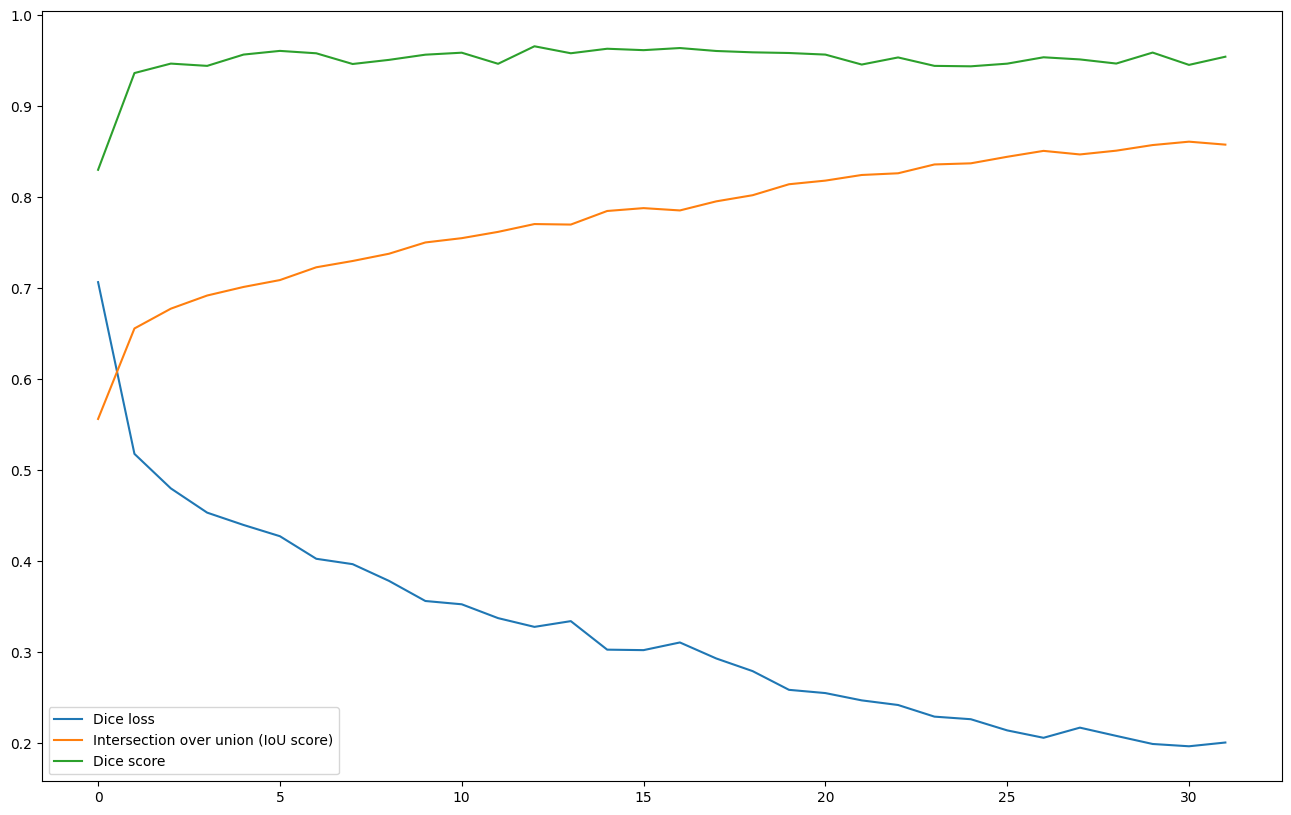

In [66]:
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Dice loss')
plt.plot(train_iou, label='Intersection over union (IoU score)')
plt.plot(train_dice, label='Dice score')
plt.legend()
plt.show()

In [67]:
def test_model(model, val_loader, device):
    model.eval()
    dice_score = 0
    iou_metric = IOU()
    iou_score = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc="Testing"):
            x = x.to(device)
            y = y.to(device).unsqueeze(1)

            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            dice_score += (2 * (preds_binary * y).sum()) / (
                (preds_binary + y).sum() + 1e-8
            )
            iou_score += iou_metric(preds_binary, y)

    avg_dice = dice_score / len(val_loader)
    avg_iou = iou_score / len(val_loader)

    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score: {avg_iou:.4f}")

    return avg_dice, avg_iou

avg_dice, avg_iou = test_model(model, val_loader, DEVICE)

Testing: 100%|██████████| 6/6 [00:00<00:00, 16.22it/s]

Average Dice Score: 0.9546
Average IoU Score: 0.5272


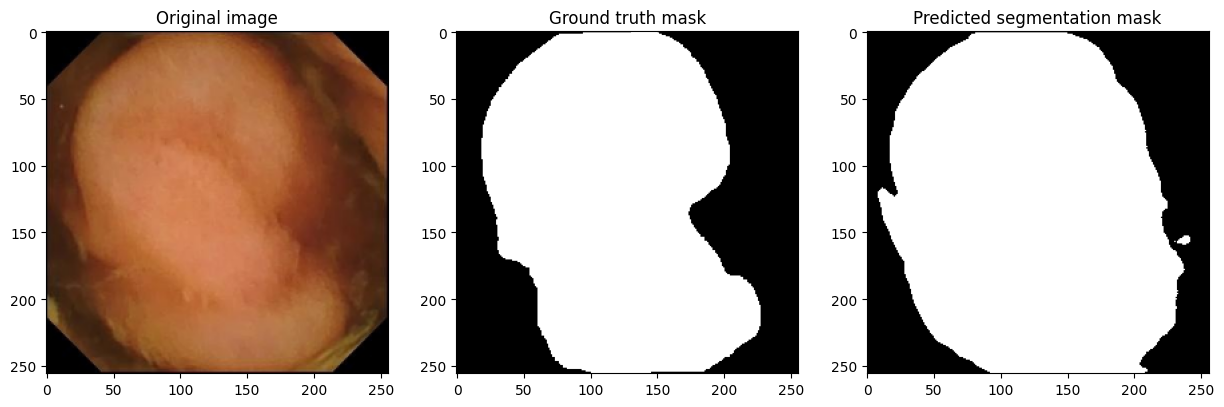

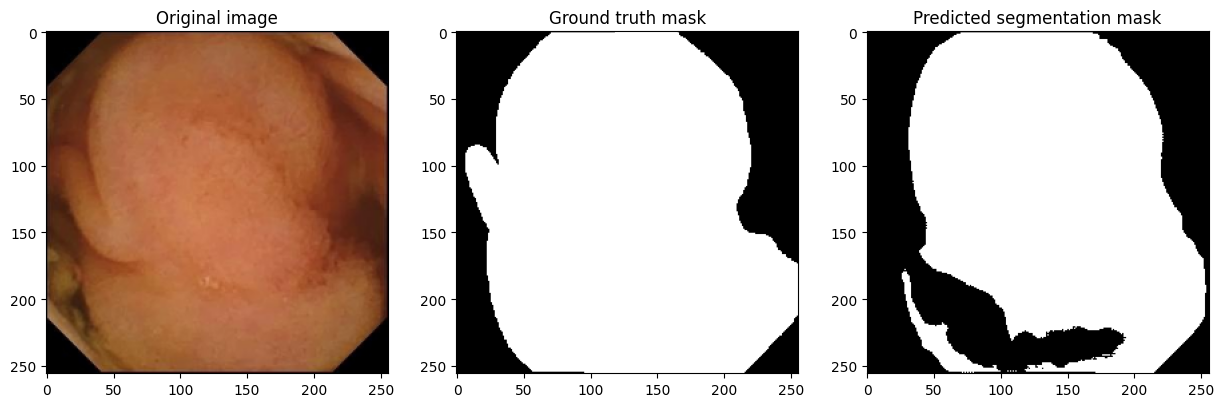

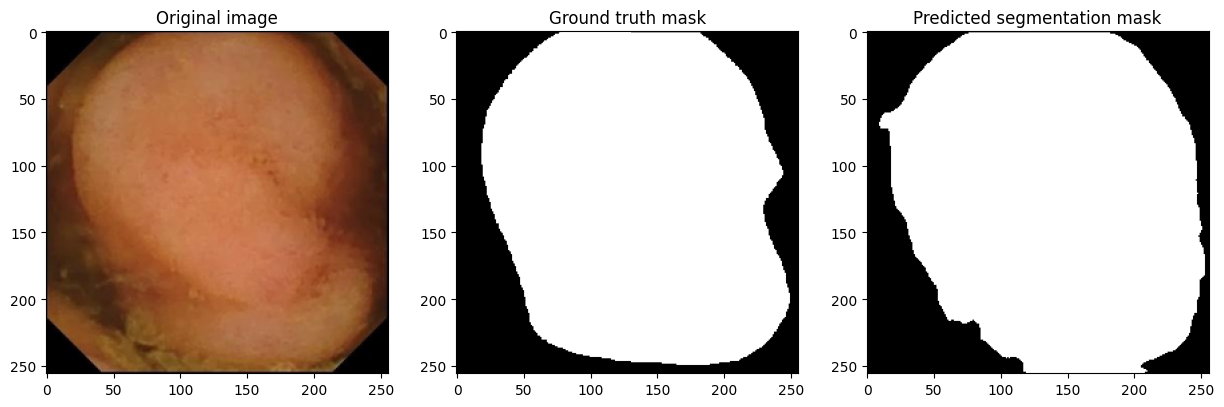

In [68]:
def visualize_predictions(model, val_loader, device, num_samples=3):
    model.eval()
    samples = 0

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds_binary = (preds > 0.5).float()

            for i in range(x.size(0)):
                if samples >= num_samples:
                    break

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.title("Original image")
                plt.imshow(np.transpose(x[i].cpu().numpy(), (1, 2, 0)))

                plt.subplot(1, 3, 2)
                plt.title("Ground truth mask")
                plt.imshow(y[i].cpu().numpy().squeeze(), cmap="gray")

                plt.subplot(1, 3, 3)
                plt.title("Predicted segmentation mask")
                plt.imshow(preds_binary[i].cpu(
                ).numpy().squeeze(), cmap="gray")

                plt.show()
                samples += 1

            if samples >= num_samples:
                break

visualize_predictions(model, val_loader, DEVICE)

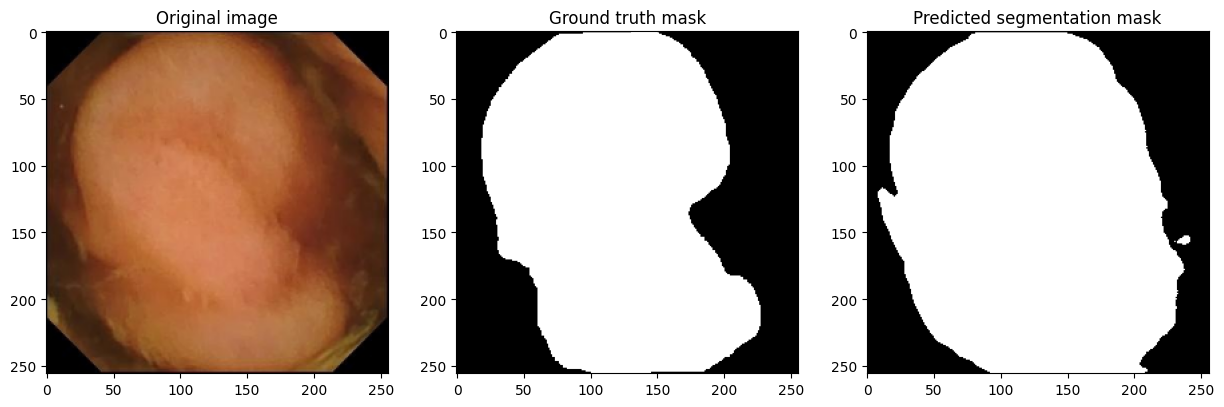

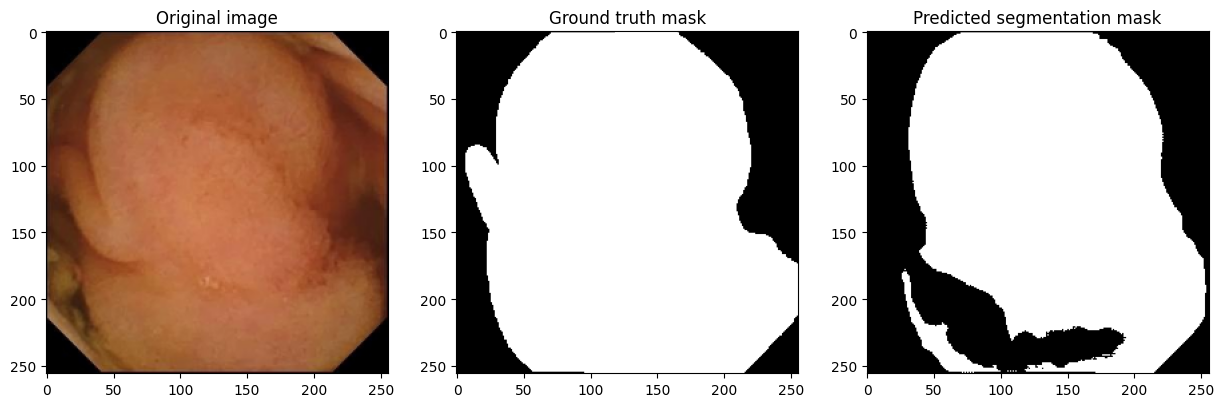

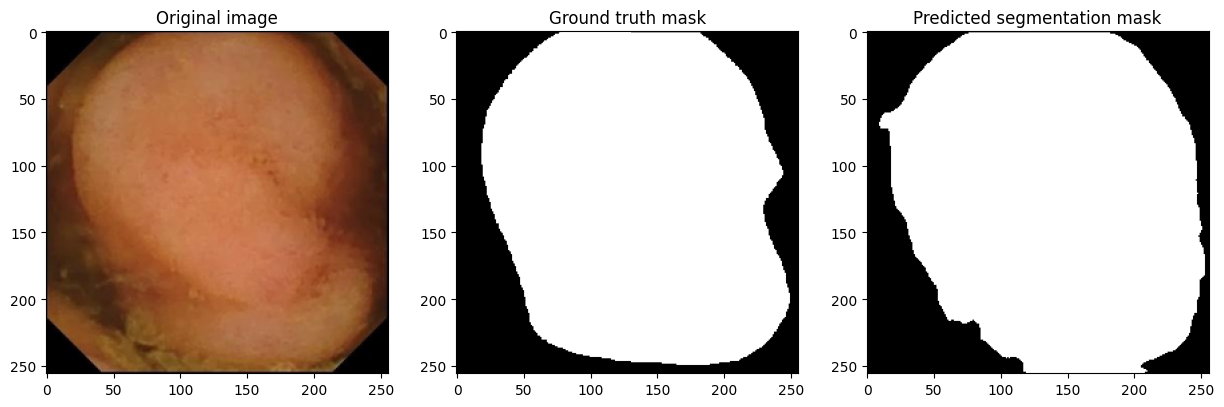

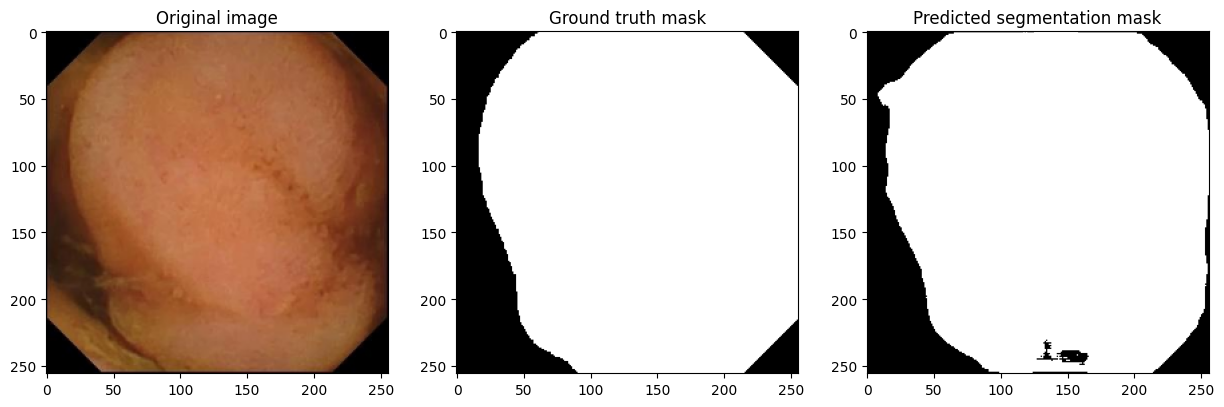

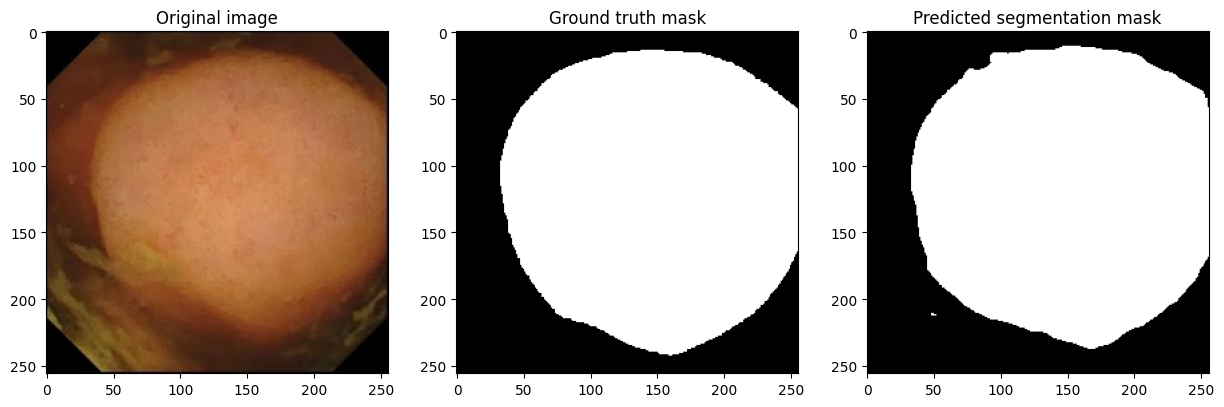

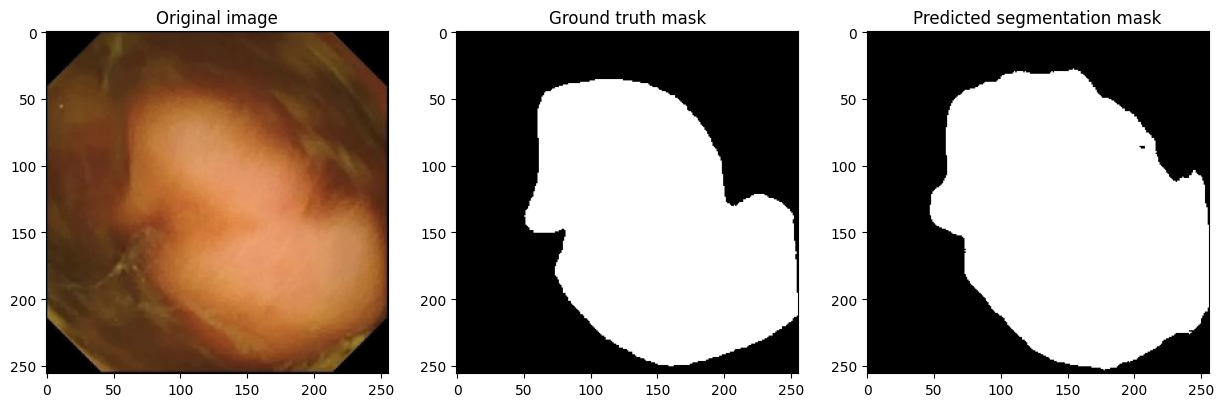

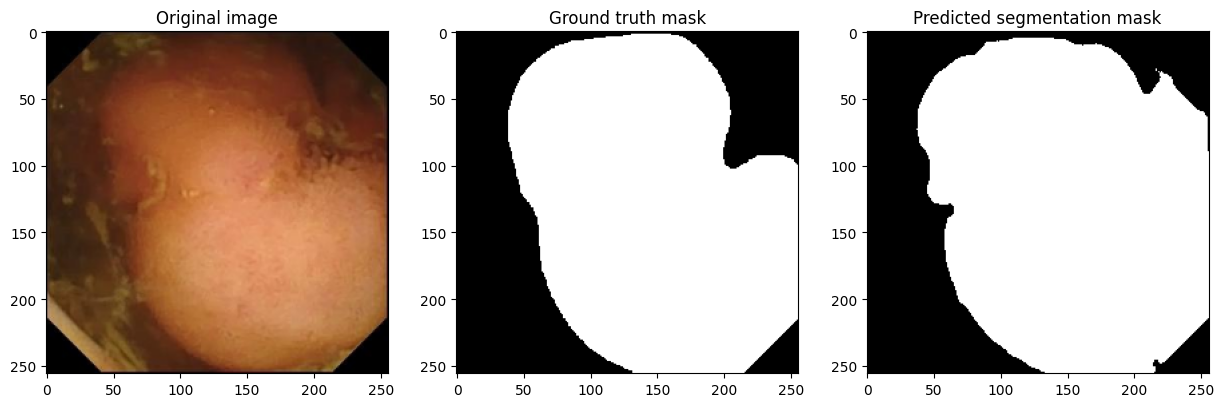

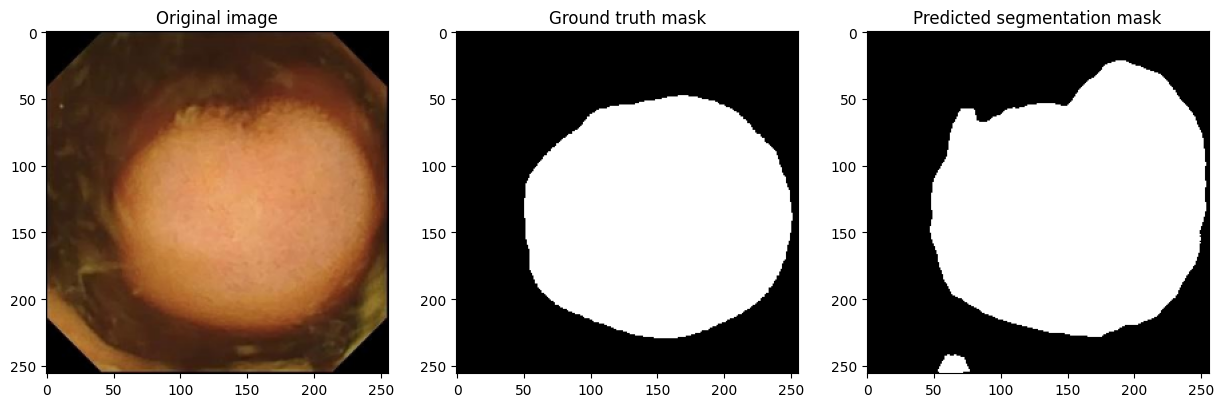

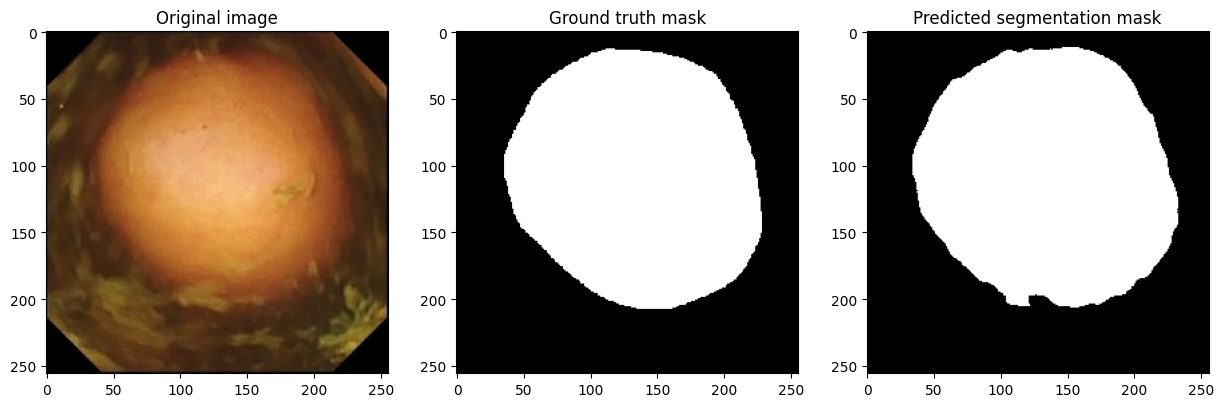

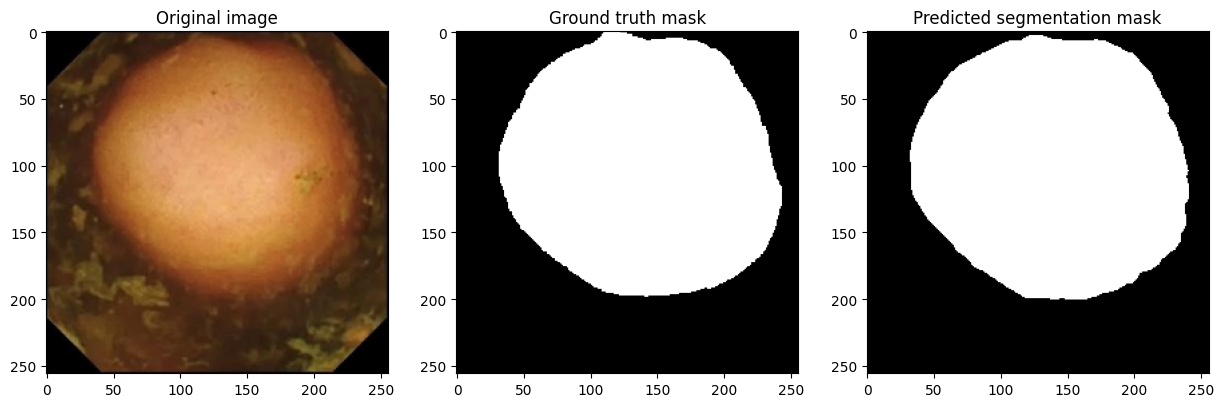

In [69]:
visualize_predictions(model, val_loader, DEVICE, num_samples=10)

In [70]:
# visualize_predictions(model, val_loader, DEVICE, num_samples=100)